**Main Code: (Start from here)**

In [1]:
# Importing relevant libraries
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import sys
import os
import csv
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from keras.layers import Dropout

In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Store all images from a directory into a Python list
def createFileList(myDir):
    fileList = []
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            fullName = os.path.join(root, name)
            fileList.append(fullName)
    return fileList

myFileList = createFileList('/content/drive/MyDrive/all_images')

#Load each image as a Pillow Image, then convert to numpy array
#Store each numpy array in a Python list
#Also store each label in a separate Python list
data = [] #Samples
labels = [] #Labels

for file in myFileList:
    name = file.split(".")
    name = name[1]
    img = Image.open(file)
    img_array = np.asarray(img)
    if img_array.shape==(200,200,3):
      data.append(img_array)
      labels.append(name)

In [4]:
# Creating an emtpty dataframe to store labels
df=pd.DataFrame(columns=['label'])
df['label']=labels

In [5]:
# Assigning category to labels and converting it to a numpy array
df['label'] = df['label'].replace(['threat'], 1)
df['label'] = df['label'].replace(['nonthreat'], 0)
df['label'] = df['label'].astype('int')
Y=df.to_numpy()

In [6]:
X = np.array(data) 
#Split the image samples and labels into training and testing sets (80/20)
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Base Model with unnormalized images

In [7]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 135424)            0

In [9]:
# Training the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 46s 99ms/step - loss: 4.7344 - accuracy: 0.8889 - val_loss: 0.2344 - val_accuracy: 0.9514
Epoch 2/10
347/347 [==============================] - 31s 88ms/step - loss: 0.3713 - accuracy: 0.9328 - val_loss: 0.1332 - val_accuracy: 0.9622
Epoch 3/10
347/347 [==============================] - 31s 88ms/step - loss: 0.0638 - accuracy: 0.9842 - val_loss: 0.0742 - val_accuracy: 0.9834
Epoch 4/10
347/347 [==============================] - 31s 88ms/step - loss: 0.0183 - accuracy: 0.9968 - val_loss: 0.0633 - val_accuracy: 0.9849
Epoch 5/10
347/347 [==============================] - 31s 88ms/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.0497 - val_accuracy: 0.9910
Epoch 6/10
347/347 [==============================] - 31s 88ms/step - loss: 0.0126 - accuracy: 0.9968 - val_loss: 0.0589 - val_accuracy: 0.9881
Epoch 7/10
347/347 [==============================] - 30s 88ms/step - loss: 0.0146 - accuracy: 0.9972 - val_loss: 0.3349 - val_accuracy:

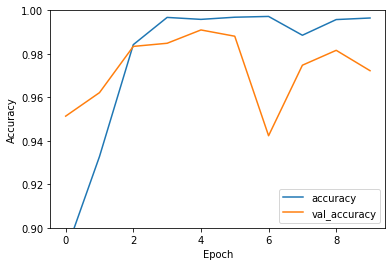

In [10]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

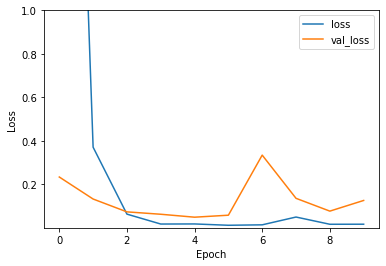

In [11]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.001, 1])
plt.legend(loc='upper right')
plt.show()

In [12]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 97.23%
Test Set Loss: 0.13


# Hyperparameter Tuning of the model.

# L1 Regularizer
## lambda = 0.01

In [13]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'valid',
        kernel_regularizer=regularizers.L1(0.01),
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 135424)           

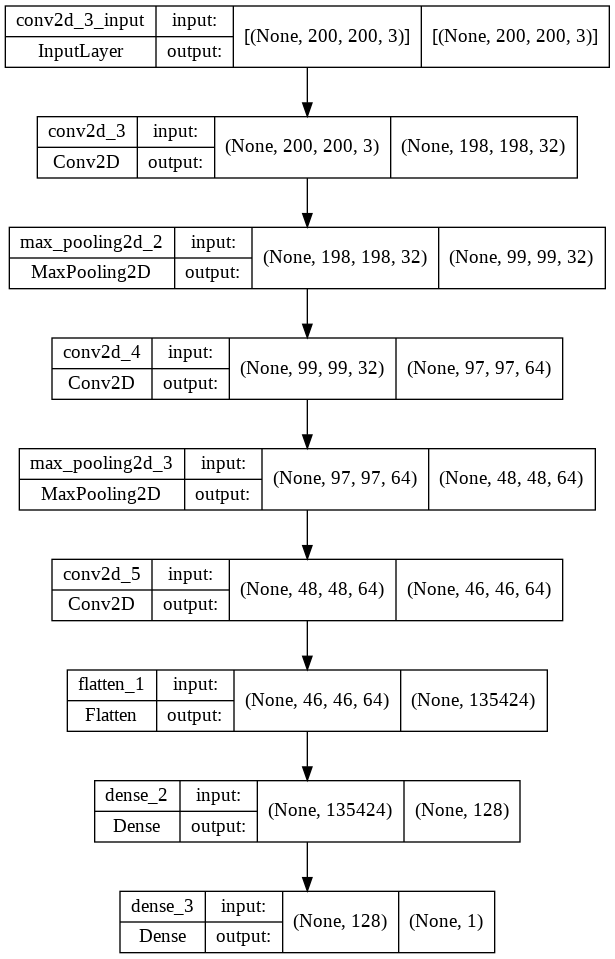

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# Traning the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 32s 90ms/step - loss: 14.1176 - accuracy: 0.9283 - val_loss: 0.7423 - val_accuracy: 0.9477
Epoch 2/10
347/347 [==============================] - 31s 89ms/step - loss: 0.6182 - accuracy: 0.9893 - val_loss: 0.6159 - val_accuracy: 0.9910
Epoch 3/10
347/347 [==============================] - 31s 89ms/step - loss: 0.5999 - accuracy: 0.9905 - val_loss: 0.6559 - val_accuracy: 0.9701
Epoch 4/10
347/347 [==============================] - 31s 89ms/step - loss: 0.6671 - accuracy: 0.9693 - val_loss: 0.5966 - val_accuracy: 0.9856
Epoch 5/10
347/347 [==============================] - 31s 89ms/step - loss: 0.6101 - accuracy: 0.9808 - val_loss: 0.5885 - val_accuracy: 0.9867
Epoch 6/10
347/347 [==============================] - 32s 92ms/step - loss: 0.6055 - accuracy: 0.9809 - val_loss: 0.6096 - val_accuracy: 0.9874
Epoch 7/10
347/347 [==============================] - 31s 89ms/step - loss: 0.6688 - accuracy: 0.9607 - val_loss: 0.6298 - val_accuracy

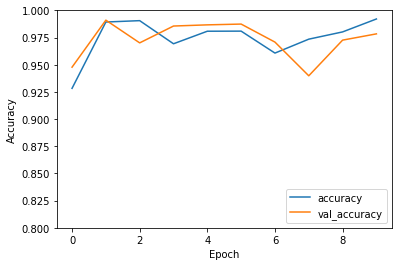

In [16]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

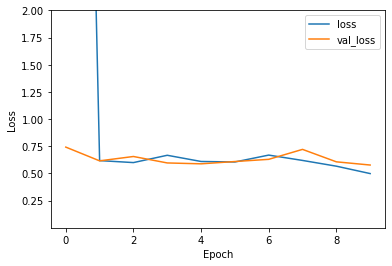

In [17]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0001, 2])
plt.legend(loc='upper right')
plt.show()

In [18]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 97.84%
Test Set Loss: 0.58


In [ ]:
# Initialize early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)


# Dropout

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 64)        0

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 29s 54ms/step - loss: 10.6012 - accuracy: 0.7999 - val_loss: 0.3447 - val_accuracy: 0.8771
Epoch 2/10
347/347 [==============================] - 18s 50ms/step - loss: 0.2859 - accuracy: 0.9018 - val_loss: 0.2161 - val_accuracy: 0.9333
Epoch 3/10
347/347 [==============================] - 17s 50ms/step - loss: 0.1615 - accuracy: 0.9438 - val_loss: 0.1419 - val_accuracy: 0.9481
Epoch 4/10
347/347 [==============================] - 18s 51ms/step - loss: 0.0844 - accuracy: 0.9740 - val_loss: 0.0979 - val_accuracy: 0.9654
Epoch 5/10
347/347 [==============================] - 18s 50ms/step - loss: 0.0527 - accuracy: 0.9827 - val_loss: 0.1256 - val_accuracy: 0.9683
Epoch 6/10
347/347 [==============================] - 18s 51ms/step - loss: 0.0521 - accuracy: 0.9838 - val_loss: 0.3668 - val_accuracy: 0.9398
Epoch 7/10
347/347 [==============================] - 18s 50ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0734 - val_accuracy

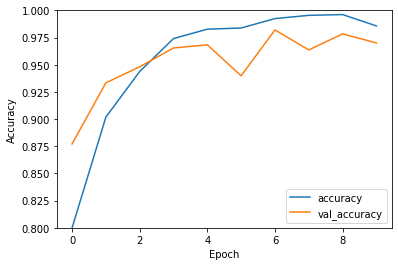

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

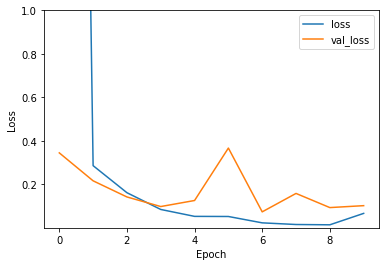

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0001, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 97.01%
Test Set Loss: 0.1


# L2 Regularizer
## lambda = 0.01

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
        kernel_regularizer=regularizers.L2(0.01),
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 141376)           

In [ ]:
# Training the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 17s 48ms/step - loss: 20.5032 - accuracy: 0.8041 - val_loss: 0.3226 - val_accuracy: 0.9229
Epoch 2/10
347/347 [==============================] - 16s 47ms/step - loss: 0.1934 - accuracy: 0.9587 - val_loss: 0.1063 - val_accuracy: 0.9841
Epoch 3/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0857 - accuracy: 0.9847 - val_loss: 0.0674 - val_accuracy: 0.9921
Epoch 4/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0725 - accuracy: 0.9889 - val_loss: 0.0772 - val_accuracy: 0.9892
Epoch 5/10
347/347 [==============================] - 16s 47ms/step - loss: 0.0682 - accuracy: 0.9913 - val_loss: 0.1009 - val_accuracy: 0.9751
Epoch 6/10
347/347 [==============================] - 16s 47ms/step - loss: 0.0688 - accuracy: 0.9903 - val_loss: 0.0735 - val_accuracy: 0.9895
Epoch 7/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0606 - accuracy: 0.9927 - val_loss: 0.0762 - val_accuracy

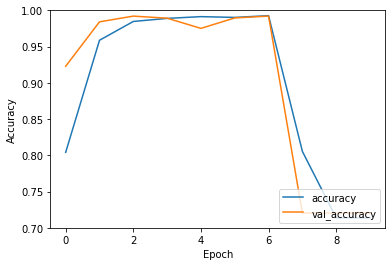

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

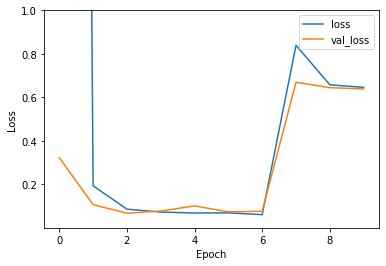

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0001, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 72.04%
Test Set Loss: 0.64


# EarlyStopping

In [ ]:
# Initializeing early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)


In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 141376)           

In [ ]:
# Traning the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),callbacks = [callback])

Epoch 1/10
347/347 [==============================] - 17s 49ms/step - loss: 10.0493 - accuracy: 0.8656 - val_loss: 0.2731 - val_accuracy: 0.9182
Epoch 2/10
347/347 [==============================] - 17s 49ms/step - loss: 0.1130 - accuracy: 0.9668 - val_loss: 0.1439 - val_accuracy: 0.9676
Epoch 3/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0659 - accuracy: 0.9855 - val_loss: 0.3510 - val_accuracy: 0.9002
Epoch 4/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0765 - accuracy: 0.9801 - val_loss: 0.1245 - val_accuracy: 0.9686
Epoch 5/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0222 - accuracy: 0.9955 - val_loss: 0.1374 - val_accuracy: 0.9780
Epoch 6/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.1424 - val_accuracy: 0.9741
Epoch 7/10
347/347 [==============================] - 16s 46ms/step - loss: 0.0344 - accuracy: 0.9935 - val_loss: 0.1767 - val_accuracy

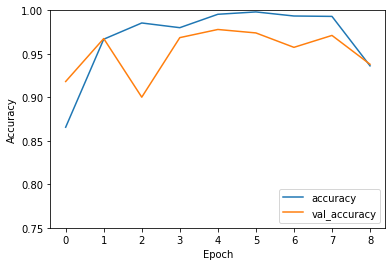

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

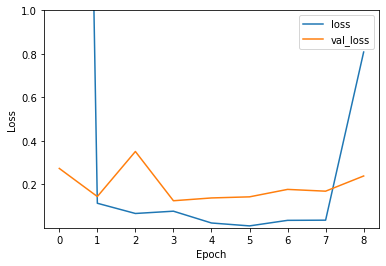

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0001, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 93.8%
Test Set Loss: 0.24


# Base model using normalized images

In [ ]:
# Normalizing the images
train_images=train_images/255.0

test_images=test_images/255.0

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')